In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

main_dataset = pd.read_excel("./buffer/1-main_dataset.xlsx")
main_dataset.drop(columns=main_dataset.columns[0], axis=1, inplace=True)

main_dataset_prepared = pd.read_excel("./buffer/2-main_dataset_prepared.xlsx")
main_dataset_prepared.drop(columns=main_dataset_prepared.columns[0], axis=1, inplace=True)

In [177]:
X = main_dataset_prepared.drop(columns=["Attrition_No", "Attrition_Yes"], axis=1)
y = main_dataset_prepared["Attrition_Yes"]

In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,  random_state=0)

In [180]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

modelMLP = MLPClassifier(random_state=0, hidden_layer_sizes=(200, 100))
modelRF = RandomForestClassifier(random_state=0)
modelKNN = KNeighborsClassifier()

modelMLP.fit(X_train, y_train)
scoreMLP = modelMLP.score(X_test, y_test)
print(scoreMLP)

modelRF.fit(X_train, y_train)
scoreRF = modelRF.score(X_test, y_test)
print(scoreRF)

modelKNN.fit(X_train, y_train)
scoreKNN = modelKNN.score(X_test, y_test)
print(scoreKNN)

0.9863945578231292
0.9875283446712018
0.8696145124716553


In [181]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score, fbeta_score, confusion_matrix


# Musire de la perforamnce d'un model
def affichage_perforamnce(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['predicted_No', 'predicted_Yes'], index=['actual_No', 'actual_Yes']))
    print()
    print('Classifier Score :', model.score(X_test, y_test))
    print('Precision Score :', precision_score(y_test, y_pred))
    print('Recall Score : ', recall_score(y_test, y_pred))
    print('Average Precision Score : ', average_precision_score(y_test, y_pred))
    print('F1 Score : ', f1_score(y_test, y_pred))
    print('F Beta Score : ', fbeta_score(y_test, y_pred, beta= 0.5))

In [182]:
affichage_perforamnce(modelMLP, X_test, y_test)
print()
affichage_perforamnce(modelRF, X_test, y_test)

            predicted_No  predicted_Yes
actual_No            735              2
actual_Yes            10            135

Classifier Score : 0.9863945578231292
Precision Score : 0.9854014598540146
Recall Score :  0.9310344827586207
Average Precision Score :  0.9287806069654978
F1 Score :  0.9574468085106382
F Beta Score :  0.9740259740259742

            predicted_No  predicted_Yes
actual_No            737              0
actual_Yes            11            134

Classifier Score : 0.9875283446712018
Precision Score : 1.0
Recall Score :  0.9241379310344827
Average Precision Score :  0.936609586363281
F1 Score :  0.9605734767025089
F Beta Score :  0.9838472834067546


In [190]:
dict(sorted({X_train.columns[i]: modelRF.feature_importances_[i] for i in range(len(X_train.columns))}.items(), reverse=True))

{'nb days off': 0.02341334198333703,
 'YearsWithCurrManager': 0.035595420514944937,
 'YearsSinceLastPromotion': 0.02874886972178781,
 'YearsAtCompany': 0.049111256337325056,
 'WorkLifeBalance': 0.025597580761174864,
 'TrainingTimesLastYear': 0.026262222728161283,
 'TotalWorkingYears': 0.0699788105480566,
 'StockOptionLevel': 0.019436795655546988,
 'Standard deviation': 0.05276929140145076,
 'PerformanceRating': 0.0072540343644665025,
 'PercentSalaryHike': 0.0371004779186887,
 'NumCompaniesWorked': 0.03571744266301252,
 'MonthlyIncome': 0.062282082992328805,
 'MaritalStatus_Single': 0.024191654514377103,
 'MaritalStatus_Married': 0.010396723241901861,
 'MaritalStatus_Divorced': 0.009250459936054325,
 'JobSatisfaction': 0.030202605154744773,
 'JobRole_Sales Representative': 0.005747093510322556,
 'JobRole_Sales Executive': 0.0096555351525858,
 'JobRole_Research Scientist': 0.007409219458373572,
 'JobRole_Research Director': 0.006863908693457732,
 'JobRole_Manufacturing Director': 0.00539

# Calule des variations

In [165]:
from sklearn.metrics import f1_score

def variation(model: RandomForestClassifier, X: pd.DataFrame, y, param: str):
    if param not in X.columns:
        return
    
    # Copy of the datasets for translating the values
    X_p = X.copy()
    X_m = X.copy()

    # Finding the translation amount
    maxi = max(X[param])
    mini = min(X[param])
    alpha = ( maxi - mini ) / 5

    # Translating the parameter
    X_p[param] += np.array([alpha]*len(X[param]))
    X_m[param] -= np.array([alpha]*len(X[param]))

    # Get the prediciton with the new model
    y_p_predicted = model.predict(X_p)
    y_m_predicted = model.predict(X_m)
    y_predicted = model.predict(X)

    # Get the scores
    y_score = sum(y_predicted)
    y_p_score = sum(y_p_predicted)
    y_m_score = sum(y_m_predicted)

    return (
        y_score - y_p_score,
        y_score - y_m_score
    )

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = md.select_dtypes(include=['int64', 'float64']).columns
categorical_features = md.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
      transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

full_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('modelRF', RandomForestClassifier())
])

In [166]:
dict_var = {}
for column in X_test.columns:
    if column in numeric_features:
        dict_var[column] = variation(modelRF, X_test, y_test, column)

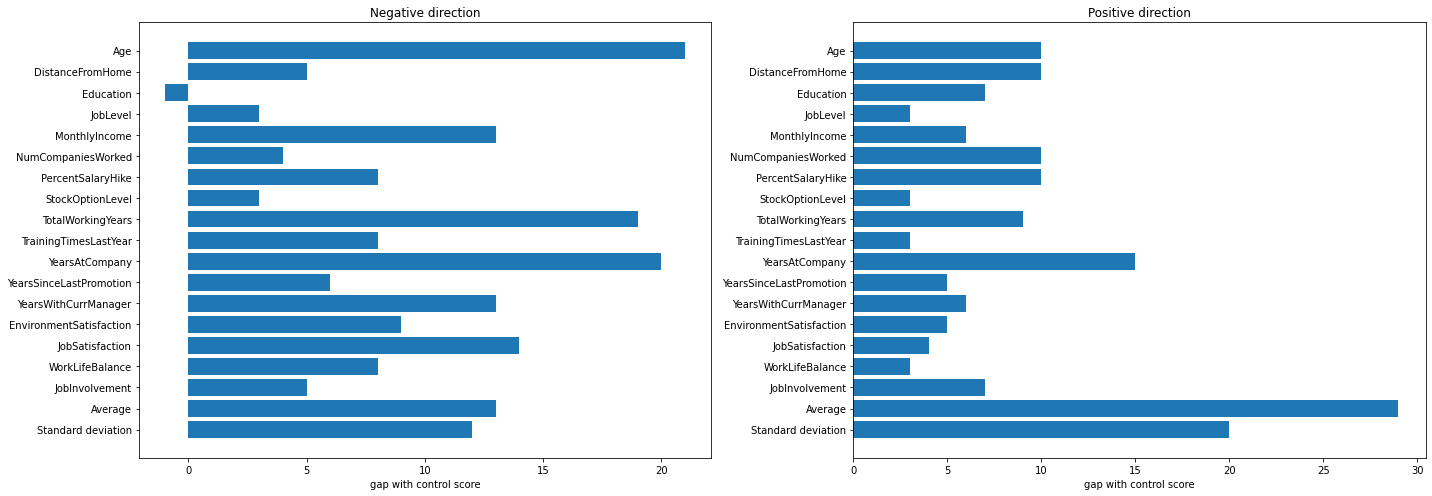

In [167]:
dict_var = {k: v for k, v in dict_var.items() if v[0] != 0 and v[1] != 0}
graph_l = dict_var.keys()
y_pos = np.arange(len(graph_l))

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

for i in range(len(axs)):
    graph_x = [j[i] for j in dict_var.values()]
    #ax = axs[i].add_axes([0,0,1,1])
    axs[i].barh(y_pos, graph_x)
    axs[i].set_yticks(y_pos, labels=graph_l)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('gap with control score')
    axs[i].set_title('Negative direction' if i == 0 else 'Positive direction')

fig.tight_layout()
plt.show()

In [155]:
{k: v for k, v in dict_var.items() if v[0] != 0 and v[1] != 0 }

{'Age': (11, 4),
 'DistanceFromHome': (6, 5),
 'MonthlyIncome': (10, 3),
 'NumCompaniesWorked': (2, 8),
 'PercentSalaryHike': (1, 6),
 'TotalWorkingYears': (11, 4),
 'YearsAtCompany': (18, 10),
 'YearsSinceLastPromotion': (3, 3),
 'YearsWithCurrManager': (7, 2),
 'Average': (6, 12),
 'nb days off': (1, -2),
 'Standard deviation': (12, 20)}